In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import creep_event_picker as cep
import obspy
import matplotlib.dates as mdates
import cmcrameri.cm as cmc
import math
%matplotlib qt


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
def check_dir(path):
    isExist = os.path.exists(path)
    if not isExist:
        # Create a new directory because it does not exist 
        os.makedirs(path, exist_ok=True)

Import creepmeter database

In [3]:
Creepmeter_dataframe = pd.read_excel('../../../Data/creepmeter_lookup_and_processing_progress.xlsx',index_col=0)
Creepmeter_dataframe.drop(Creepmeter_dataframe[Creepmeter_dataframe['Picked'] != 'YES'].index,inplace=True)
#Creepmeter_dataframe.drop(Creepmeter_dataframe[Creepmeter_dataframe['Manual_check_initial'] == 'N/A'].index,inplace=True)
#Creepmeter_dataframe.drop(Creepmeter_dataframe[Creepmeter_dataframe["Checked for missing events"] != 'YES'].index,inplace=True)
#Creepmeter_dataframe.drop(Creepmeter_dataframe[Creepmeter_dataframe["Checked start picks"] == 'YES'].index,inplace=True)
#Creepmeter_dataframe.drop(Creepmeter_dataframe[Creepmeter_dataframe["Checked end picks"] != 'NO'].index,inplace=True)

Creepmeter_dataframe.reset_index(inplace=True)
Creepmeter_dataframe.drop(['Index'],axis=1,inplace=True)
Creepmeter_dataframe

,Region,Sub_region_map,Network,Creepmeter_full_name,Creepmeter_abbrv,File_code,Start Time,End Time,"Sampling rate, Hz","Sampling rate, mins",...,Cov_max_duration_Fixed,Fitting,Calculate G_value,Groupings for sub events,Calculate C-value,Colours,Colour_maps,Colour_maps2,Colour_maps3,Notes
0,Pakistan,Chaman_Fault,Chaman_Fault,Chaman,CHA1,cha_0,2019-02-17T15:37:00.000000Z,2020-11-21T13:27:00.000000Z,0.001667,10,...,YES,NO,NO,NO,NO,#8c0273,#260d40,#9eb0ff,red,NaN
1,Turkey,North_Anatolian_Fault,North_Anatolian_Fault,Ismetpasa North Wall,INW1,inw_0,2014-05-22T00:38:00.000000Z,2019-10-08T09:08:00.000000Z,0.000556,30,...,NO,NO,NO,NO,NO,#8f1966,#321d4e,#80acf1,#2c55a2,NaN
2,Turkey,North_Anatolian_Fault,North_Anatolian_Fault,Ismetpasa North Wall,INW1,inw_1,2019-10-09T04:41:00.000000Z,2023-09-16T10:12:00.000000Z,0.016667,1,...,NO,NO,NO,NO,NO,#8e136a,#2e184a,#8aaef5,#2c55a1,"so many small events, grouped for now but am w..."
3,Turkey,North_Anatolian_Fault,North_Anatolian_Fault,Ismetpasa South Wall,ISW1,isw_0,2020-01-01T00:00:00.000000Z,2023-06-21T23:35:00.000000Z,0.016667,1,...,NO,NO,NO,NO,NO,#901f62,#362354,#74aaeb,#356598,"Only major events picked, more detailed look m..."
4,Turkey,North_Anatolian_Fault,North_Anatolian_Fault,West Sazlik,WSZ1,wsz_0,2017-12-04T09:08:00.000000Z,2018-10-05T06:08:00.000000Z,0.003333,5,...,NaN,NaN,NO,NaN,NaN,#91245e,#392758,#6aa8e5,#42748b,No creep events to report here during this per...
5,Turkey,North_Anatolian_Fault,North_Anatolian_Fault,West Sazlik,WSZ1,wsz_1,2018-10-05T08:00:00.000000Z,2023-06-07T12:20:00.000000Z,0.016667,1,...,NO,NO,NO,NO,NO,#92295a,#3d2d5d,#5da5dd,#42748b,NaN
6,California,Hayward,Hayward_Fault,Pt Pinole,CPP1,cpp_0,1995-08-25T20:00:00.000000Z,2020-01-20T23:40:00.000000Z,0.001667,10,...,NO,NO,NO,NO,NO,#922e55,#413362,#519fd3,#65024b,Surges every now and again but not sure they a...
7,California,Hayward,Hayward_Fault,Pt Pinole,CPP1,cpp_1,2020-01-22T19:51:00.000000Z,2024-02-05T11:56:00.000000Z,0.016667,1,...,NO,NO,NO,NO,NO,#933252,#443766,#489aca,#65024b,"Not sure if they are actually creep events, lo..."
8,California,Hayward,Hayward_Fault,Temescal,CTM1,ctm_0,1997-03-06T00:00:00.000000Z,2006-08-22T00:00:00.000000Z,0.000278,60,...,NaN,NaN,NO,NaN,NaN,#94374e,#483d6b,#3f92be,#8e2c74,"Sampling rate too low, difficult to tell what ..."
9,California,Hayward,Hayward_Fault,Temescal,CTM1,ctm_1,2006-08-22T06:10:00.000000Z,2020-01-07T16:20:00.000000Z,0.001667,10,...,NO,NO,NO,NO,NO,#943b4b,#4b416f,#398bb4,#8e2c74,Awkward to pick… need to think about it a litt...


In [4]:
cutter = 2
n=10
cmap = cmc.roma #select the colormap

slicedCM = cmap(np.linspace(0, 1, cutter+1)) #list of colors that make up the colormap, can be called by using slicedCM[j] where j is the loop number in the fore loop

In [5]:
plt.close('all')
for i in range(16,18):#len(Creepmeter_dataframe)):
    path = "../../../Data/{p}/SAC/{q}.SAC".format(p=Creepmeter_dataframe.Network.iloc[i],q =Creepmeter_dataframe.File_code.iloc[i])
    path_save = "../../../Data/{p}/Picks/".format(p=Creepmeter_dataframe.Network.iloc[i])
    check_dir(path_save)
    print(path)
    st = obspy.read(path)
    tr = st[0]
    tr.interpolate(sampling_rate=tr.stats.sampling_rate)
    tm = tr.times("utcdatetime")
    creep = tr.data
    sample_rate =  round(tr.stats.delta)/60
    tm_dt = []
    for w in range(len(tm)):
        tm_new = tm[w].datetime
        tm_dt.append(tm_new)
    print('now interpolate')
    tm_int, creep_int, upsampled = cep.interpolate(tm_dt,creep,sample_rate,5)
    


    
    #plt.plot(tm_int,creep_int)

    df_picks = pd.read_csv("../../../Data/{p}/Picks/{q}_picks.csv".format(p=Creepmeter_dataframe.Network.iloc[i],\
                                                                          q =Creepmeter_dataframe.File_code.iloc[i]),index_col=0)
    df_picks.sort_values(by='ST',inplace=True)
    try:
        df_picks.reset_index(inplace=True)
    except:
        dummy=10
    
   
    df_end=pd.DataFrame(columns=['ET'])
    df_start=pd.DataFrame(columns=['ST'])
    QC = []
    for p in range(math.ceil(len(df_picks)/cutter)):
        fig = plt.figure(figsize=(7,6))
        ax = plt.subplot(1,1,1)

        df_selecta = df_picks.copy(deep=True)
        boolarr = np.logical_and(df_selecta.index >= cutter*(p),df_selecta.index < cutter*(p+1))
        df_selecta = df_selecta[boolarr]
        #print(df_selecta)
        fig.suptitle('events {a} - {b} of {c}'.format(a = df_selecta.index[0]+1,b= df_selecta.index[-1]+1,c =len(df_picks) ))
        boolarr_selecta = np.logical_and(np.array(tm_int)>=pd.to_datetime(df_selecta.ST.iloc[0]).replace(tzinfo=None)\
                                         -dt.timedelta(days=10),\
                                                np.array(tm_int)<=pd.to_datetime(df_selecta.ET.iloc[-1]).replace(tzinfo=None)\
                                                    +dt.timedelta(days = 30))
        tm_selecta = tm_int[boolarr_selecta]
        creep_selecta = creep_int[boolarr_selecta]
        plt.plot(tm_selecta,creep_selecta,color='k')

        for j in range(len(df_picks)):
            boolarr = np.logical_and(np.array(tm_selecta)>=pd.to_datetime(df_picks.ST.iloc[j]).replace(tzinfo=None),\
                                            np.array(tm_selecta)<=pd.to_datetime(df_picks.ET.iloc[j]).replace(tzinfo=None))
            event_creep = creep_selecta[boolarr]
            event_time = tm_selecta[boolarr]
            #print(event_time)
            ax.plot(event_time,event_creep,color='orange',linewidth=3)
            try:
                ax.text(event_time[0],event_creep[0],'{k}/{n}'.format(k=df_picks.index[j]+1,n=len(df_picks)),color='green')
                ax.text(event_time[-1],event_creep[-1],'{k}/{n}'.format(k=df_picks.index[j]+1,n=len(df_picks)),color='red')
            except IndexError:
                dummy=10

        ax.set_xlim([tm_selecta[0],tm_selecta[-1]])
        ax.set_ylim([np.min(creep_selecta),np.max(creep_selecta)])
        for j in range(len(df_selecta)):
            if df_selecta["Quality_check"].iloc[j]=="CE":
                color='green'
            else:
                color="red"
            boolarr = np.logical_and(np.array(tm_selecta)>=pd.to_datetime(df_selecta.ST.iloc[j]).replace(tzinfo=None),\
                                            np.array(tm_selecta)<=pd.to_datetime(df_selecta.ET.iloc[j]).replace(tzinfo=None))
            event_creep = creep_selecta[boolarr]
            event_time = tm_selecta[boolarr]
            #print(event_time)
            ax.plot(event_time,event_creep,color=color,linewidth=j+1,zorder=100-(j*20))
            ax.scatter([event_time[0]],[event_creep[0]],c='green',marker='s',s=20)
            ax.scatter([event_time[-1]],[event_creep[-1]],c='red',zorder=10,s=10)
            ax.text(event_time[0],event_creep[0],'{k}/{n}'.format(k=df_selecta.index[j]+1,n=len(df_picks)),color='green')
            ax.text(event_time[-1],event_creep[-1],'{k}/{n}'.format(k=df_selecta.index[j]+1,n=len(df_picks)),color='red')

        
        ##### define start, end and QC ####
        
        
        scale = 1.1
        zp = cep.ZoomPan()
        figZoom = zp.zoom_factory(ax, base_scale = scale)
        figPan = zp.pan_factory(ax)
        s = 1
        fig.set_size_inches(11,11)
        fig.tight_layout()
        plt.show()
        for m in range(len(df_selecta)):
            print('{m}/{n}'.format(m=df_selecta.index[m]+1,n=len(df_picks)))

            print('is the start pick good?\n esc=yes, click=no')
            check_start = plt.ginput(1,timeout = -1)
            if len(check_start) ==1:
                for sublist in check_start:
                    df = pd.DataFrame({'ST':[sublist[0]]})
                    df_start = pd.concat([df_start,df])
                print('new start picked\n {k}'.format(k=mdates.num2date(sublist[0])))
            else:
                print('start all good! :D')
                df = pd.DataFrame({'ST':mdates.date2num([df_selecta.ST.loc[df_selecta.index[m]]])})
                df_start = pd.concat([df_start,df])

            print("now pick the end\n esc=keep current, click=pick new")
            pts = plt.ginput(1,timeout = -1)
            if len(pts)==1:
                for sublist in pts:
                    df = pd.DataFrame({'ET':[sublist[0]]})
                    df_end = pd.concat([df_end,df])
                    print('new end picked\n {k}'.format(k=mdates.num2date(sublist[0])))
            else:
                print('end all good! :D')
                df = pd.DataFrame({'ET':mdates.date2num([df_selecta.ET.loc[df_selecta.index[m]]])})
                df_end = pd.concat([df_end,df])
            
            
            print('is this a creep event?\n esc=no, click=yes')
            check_pts = plt.ginput(1,timeout = -1)
            
            if len(check_pts) == 1:
                QC.append('CE')
                print('YES!! :D')
            else:
                QC.append('NCE')
                print('Nope :(')

        plt.close()
    for r in range(len(df_end)):
        time_convert = mdates.num2date(float(df_end.ET.iloc[r]))
        s3 = pd.Series(time_convert).dt.round("1min")
        df_end.ET.iloc[r] = s3.iloc[0].replace(tzinfo=None)  

    
    for r in range(len(df_start)):
        time_convert = mdates.num2date(float(df_start.ST.iloc[r]))
        s3 = pd.Series(time_convert).dt.round("1min")
        df_start.ST.iloc[r] = s3.iloc[0].replace(tzinfo=None) 
    
    #df_picks_end.ET= mdates.num2date(df_picks_end.ET)
    df_end.reset_index(inplace=True)
    df_start.reset_index(inplace=True)
    df_end.drop(columns=['index'],inplace=True)
    df_start.drop(columns=['index'],inplace=True)
    
    df_picks['ET_new'] = df_end['ET']
    df_picks['ST_new'] = df_start['ST']
    df_picks['ST'] = df_picks['ST'].astype(str).str[0:19]
    df_picks['ET'] = df_picks['ET'].astype(str).str[0:19]
    df_picks['ET_new'] = df_picks['ET_new'].astype(str).str[0:19]
    df_picks['ST_new'] = df_picks['ST_new'].astype(str).str[0:19]
    df_picks['Quality_check_new'] = QC
    print(df_picks)
    #df_picks.to_csv("../../../Data/{p}/Picks/{q}_picks.csv".format(p=Creepmeter_dataframe.Network.iloc[i],\
    #                                                                q =Creepmeter_dataframe.File_code.iloc[i]))

../../../Data/Hayward_Fault/SAC/cfw_0.SAC
now interpolate


/Users/dagi9522/Library/CloudStorage/OneDrive-UCB-O365/Documents/Scripts/Creepmeter_processing/Creepmeter_data_processing/creep_event_picker.py:638: FutureWarning: DataFrame.interpolate with method=ffill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  interpolated = upsampled.interpolate(method='ffill') #interpolate the dataset to get a continious record evenly spaced at 10 mins


1/76
is the start pick good?
 esc=yes, click=no


KeyboardInterrupt: 

add event 2002-05-08 19:20 -- 2002-05-25 00:00
add event 2014-11-01 03:30 -- 2014-11-11 00:00
add event 2023-02-23 10:10 -- 2023-02-24 00:00

In [9]:
st[0].stats

         network: Chaman_F
         station: cha
        location: 00
         channel: slip
       starttime: 2019-02-17T15:37:00.000000Z
         endtime: 2020-11-21T13:16:58.654968Z
   sampling_rate: 0.0016666667070239782
           delta: 599.9999854713682
            npts: 92579
           calib: 1.0
         _format: SAC
      processing: ["ObsPy 1.4.1: interpolate(args=()::method='weighted_average_slopes'::npts=None::sampling_rate=0.0016666667070239782::starttime=None::time_shift=0.0)"]
             sac: AttribDict({'delta': 600.0, 'depmin': -1.0603, 'depmax': 6.327, 'scale': 1.0, 'b': 0.0, 'e': 55547400.0, 'depmen': nan, 'nzyear': 2019, 'nzjday': 48, 'nzhour': 15, 'nzmin': 37, 'nzsec': 0, 'nzmsec': 0, 'nvhdr': 6, 'npts': 92580, 'iftype': 1, 'iztype': 9, 'leven': 1, 'lpspol': 1, 'lovrok': 1, 'lcalda': 0, 'kstnm': 'cha', 'khole': '00', 'kcmpnm': 'slip', 'knetwk': 'Chaman_F'})

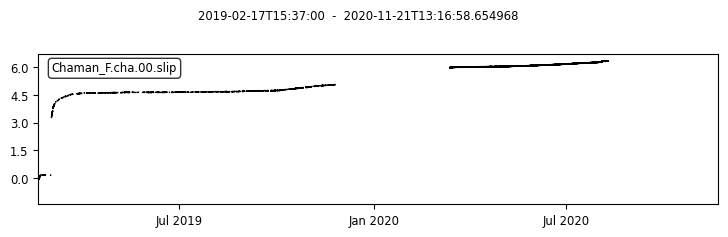

In [19]:
%matplotlib inline
tr = st[0]
tr.plot();

In [ ]:
df_selecta

In [9]:
plt.close('all')
for i in range(16,18):#len(Creepmeter_dataframe)):
    path = "../../../Data/{p}/SAC/{q}.SAC".format(p=Creepmeter_dataframe.Network.iloc[i],q =Creepmeter_dataframe.File_code.iloc[i])
    path_save = "../../../Data/{p}/Picks/".format(p=Creepmeter_dataframe.Network.iloc[i])
    check_dir(path_save)
    print(path)
    st = obspy.read(path)
    tr = st[0]
    tr.interpolate(sampling_rate=tr.stats.sampling_rate)
    tm = tr.times("utcdatetime")
    creep = tr.data
    sample_rate =  round(tr.stats.delta)/60
    tm_dt = []
    for w in range(len(tm)):
        tm_new = tm[w].datetime
        tm_dt.append(tm_new)
    print('now interpolate')
    tm_int, creep_int, upsampled = cep.interpolate(tm_dt,creep,sample_rate,5)
    


    
    #plt.plot(tm_int,creep_int)

    df_picks = pd.read_csv("../../../Data/{p}/Picks/{q}_picks.csv".format(p=Creepmeter_dataframe.Network.iloc[i],\
                                                                          q =Creepmeter_dataframe.File_code.iloc[i]),index_col=0)
    df_picks.sort_values(by='ST_new',inplace=True)
    try:
        df_picks.reset_index(inplace=True)
    except:
        dummy=10
    
   
    df_end=pd.DataFrame(columns=['ET_new'])
    df_start=pd.DataFrame(columns=['ST_new'])
    QC = []
    for p in range(math.ceil(len(df_picks)/cutter)):
        fig = plt.figure(figsize=(7,6))
        ax = plt.subplot(1,1,1)

        df_selecta = df_picks.copy(deep=True)
        boolarr = np.logical_and(df_selecta.index >= cutter*(p),df_selecta.index < cutter*(p+1))
        df_selecta = df_selecta[boolarr]
        #print(df_selecta)
        fig.suptitle('events {a} - {b} of {c}'.format(a = df_selecta.index[0]+1,b= df_selecta.index[-1]+1,c =len(df_picks) ))
        boolarr_selecta = np.logical_and(np.array(tm_int)>=pd.to_datetime(df_selecta.ST.iloc[0]).replace(tzinfo=None)\
                                         -dt.timedelta(days=10),\
                                                np.array(tm_int)<=pd.to_datetime(df_selecta.ET.iloc[-1]).replace(tzinfo=None)\
                                                    +dt.timedelta(days = 30))
        tm_selecta = tm_int[boolarr_selecta]
        creep_selecta = creep_int[boolarr_selecta]
        plt.plot(tm_selecta,creep_selecta,color='k')

        for j in range(len(df_picks)):
            boolarr = np.logical_and(np.array(tm_selecta)>=pd.to_datetime(df_picks.ST_new.iloc[j]).replace(tzinfo=None),\
                                            np.array(tm_selecta)<=pd.to_datetime(df_picks.ET_new.iloc[j]).replace(tzinfo=None))
            event_creep = creep_selecta[boolarr]
            event_time = tm_selecta[boolarr]
            #print(event_time)
            ax.plot(event_time,event_creep,color='orange',linewidth=3)
            try:
                ax.text(event_time[0],event_creep[0],'{k}/{n}'.format(k=df_picks.index[j]+1,n=len(df_picks)),color='green')
                ax.text(event_time[-1],event_creep[-1],'{k}/{n}'.format(k=df_picks.index[j]+1,n=len(df_picks)),color='red')
            except IndexError:
                dummy=10

        ax.set_xlim([tm_selecta[0],tm_selecta[-1]])
        ax.set_ylim([np.min(creep_selecta),np.max(creep_selecta)])
        for j in range(len(df_selecta)):
            if df_selecta["Quality_check_new"].iloc[j]=="CE":
                color='green'
            else:
                color="red"
            boolarr = np.logical_and(np.array(tm_selecta)>=pd.to_datetime(df_selecta.ST_new.iloc[j]).replace(tzinfo=None),\
                                            np.array(tm_selecta)<=pd.to_datetime(df_selecta.ET_new.iloc[j]).replace(tzinfo=None))
            event_creep = creep_selecta[boolarr]
            event_time = tm_selecta[boolarr]
            #print(event_time)
            ax.plot(event_time,event_creep,color=color,linewidth=j+1,zorder=100-(j*20))
            try:
                ax.scatter([event_time[0]],[event_creep[0]],c='green',marker='s',s=20)
                ax.scatter([event_time[-1]],[event_creep[-1]],c='red',zorder=10,s=10)
                ax.text(event_time[0],event_creep[0],'{k}/{n}'.format(k=df_selecta.index[j]+1,n=len(df_picks)),color='green')
                ax.text(event_time[-1],event_creep[-1],'{k}/{n}'.format(k=df_selecta.index[j]+1,n=len(df_picks)),color='red')
            except IndexError:
                dummy=10

        
        ##### define start, end and QC ####
        
        
        scale = 1.1
        zp = cep.ZoomPan()
        figZoom = zp.zoom_factory(ax, base_scale = scale)
        figPan = zp.pan_factory(ax)
        s = 1
        fig.set_size_inches(11,11)
        fig.tight_layout()
        plt.show()
        for m in range(len(df_selecta)):
            print('{m}/{n}'.format(m=df_selecta.index[m]+1,n=len(df_picks)))

            print('is the start pick good?\n esc=yes, click=no')
            check_start = plt.ginput(1,timeout = -1)
            if len(check_start) ==1:
                for sublist in check_start:
                    df = pd.DataFrame({'ST':[sublist[0]]})
                    df_start = pd.concat([df_start,df])
                print('new start picked\n {k}'.format(k=mdates.num2date(sublist[0])))
            else:
                print('start all good! :D')
                df = pd.DataFrame({'ST':mdates.date2num([df_selecta.ST.loc[df_selecta.index[m]]])})
                df_start = pd.concat([df_start,df])

            print("now pick the end\n esc=keep current, click=pick new")
            pts = plt.ginput(1,timeout = -1)
            if len(pts)==1:
                for sublist in pts:
                    df = pd.DataFrame({'ET':[sublist[0]]})
                    df_end = pd.concat([df_end,df])
                    print('new end picked\n {k}'.format(k=mdates.num2date(sublist[0])))
            else:
                print('end all good! :D')
                df = pd.DataFrame({'ET':mdates.date2num([df_selecta.ET.loc[df_selecta.index[m]]])})
                df_end = pd.concat([df_end,df])
            
            
            print('is this a creep event?\n esc=no, click=yes')
            check_pts = plt.ginput(1,timeout = -1)
            
            if len(check_pts) == 1:
                QC.append('CE')
                print('YES!! :D')
            else:
                QC.append('NCE')
                print('Nope :(')

        plt.close()
    for r in range(len(df_end)):
        time_convert = mdates.num2date(float(df_end.ET.iloc[r]))
        s3 = pd.Series(time_convert).dt.round("1min")
        df_end.ET.iloc[r] = s3.iloc[0].replace(tzinfo=None)  

    
    for r in range(len(df_start)):
        time_convert = mdates.num2date(float(df_start.ST.iloc[r]))
        s3 = pd.Series(time_convert).dt.round("1min")
        df_start.ST.iloc[r] = s3.iloc[0].replace(tzinfo=None) 
    
    #df_picks_end.ET= mdates.num2date(df_picks_end.ET)
    df_end.reset_index(inplace=True)
    df_start.reset_index(inplace=True)
    df_end.drop(columns=['index'],inplace=True)
    df_start.drop(columns=['index'],inplace=True)
    
    df_picks['ET_new'] = df_end['ET']
    df_picks['ST_new'] = df_start['ST']
    df_picks['ST'] = df_picks['ST'].astype(str).str[0:19]
    df_picks['ET'] = df_picks['ET'].astype(str).str[0:19]
    df_picks['ET_new'] = df_picks['ET_new'].astype(str).str[0:19]
    df_picks['ST_new'] = df_picks['ST_new'].astype(str).str[0:19]
    df_picks['Quality_check_new'] = QC
    print(df_picks)
    #df_picks.to_csv("../../../Data/{p}/Picks/{q}_picks.csv".format(p=Creepmeter_dataframe.Network.iloc[i],\
    #                                                                q =Creepmeter_dataframe.File_code.iloc[i]))

../../../Data/Hayward_Fault/SAC/cfw_0.SAC
now interpolate
1/76
is the start pick good?
 esc=yes, click=no


/Users/dagi9522/Library/CloudStorage/OneDrive-UCB-O365/Documents/Scripts/Creepmeter_processing/Creepmeter_data_processing/creep_event_picker.py:638: FutureWarning: DataFrame.interpolate with method=ffill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  interpolated = upsampled.interpolate(method='ffill') #interpolate the dataset to get a continious record evenly spaced at 10 mins


start all good! :D
now pick the end
 esc=keep current, click=pick new
end all good! :D
is this a creep event?
 esc=no, click=yes
YES!! :D
2/76
is the start pick good?
 esc=yes, click=no
start all good! :D
now pick the end
 esc=keep current, click=pick new
end all good! :D
is this a creep event?
 esc=no, click=yes
YES!! :D
3/76
is the start pick good?
 esc=yes, click=no
start all good! :D
now pick the end
 esc=keep current, click=pick new
end all good! :D
is this a creep event?
 esc=no, click=yes
YES!! :D
4/76
is the start pick good?
 esc=yes, click=no
start all good! :D
now pick the end
 esc=keep current, click=pick new
end all good! :D
is this a creep event?
 esc=no, click=yes
YES!! :D
5/76
is the start pick good?
 esc=yes, click=no
start all good! :D
now pick the end
 esc=keep current, click=pick new
end all good! :D
is this a creep event?
 esc=no, click=yes
YES!! :D
6/76
is the start pick good?
 esc=yes, click=no
start all good! :D
now pick the end
 esc=keep current, click=pick new


KeyboardInterrupt: 

In [ ]:
37 is CE